model

In [1]:
from model import Dit, DitModelArgs

load model

In [2]:
config = DitModelArgs(n_labels=10, in_channels=1)
model = Dit(config=config)
model_params = sum(p.numel() for p in model.parameters())
model_params_size = model_params * 4 / (1024 ** 2)
print("model parameter:", model_params)
print(f'Model size: {model_params_size:.2f} MB')

model parameter: 30708480
Model size: 117.14 MB


dataloader

In [3]:
from torch.utils.data import DataLoader
from utils.dataset import FigureDataSet
from torchvision import transforms
from torchvision.transforms import Compose

#
#---Here Set Your Image Data Path---
#
root_dir = 'your_train_data'
"""Stucture be like:
        /your_train_data
            /0
                image1.jpg
                image2.jpg
            /1
                image1.jpg
                image2.jpg
            /2
                image1.jpg
                image2.jpg
            /...
"""
transform = Compose([transforms.Grayscale(num_output_channels=1),transforms.ToTensor(), transforms.Resize((16, 16))])
dataset = FigureDataSet(root_dir=root_dir, transform=transform)
dataloader = DataLoader(dataset, batch_size=300, shuffle=True)
print("dataset size:", len(dataset))
print("dataloader size:", len(dataloader))

dataset size: 60000
dataloader size: 200


test_utils

show origin image

torch.Size([1, 16, 16])


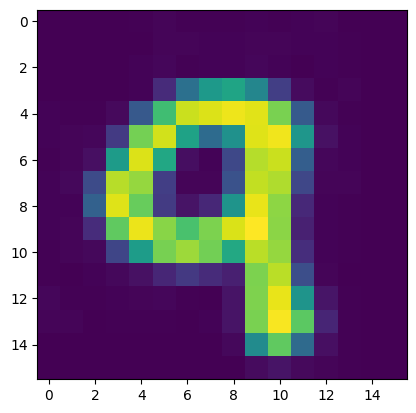

In [20]:
import matplotlib.pyplot as plt
img = dataset[59000][0]
print(img.shape)
img_show = img.permute(1,2,0)
plt.imshow(img_show) # show the origin image

show forward_add_noise

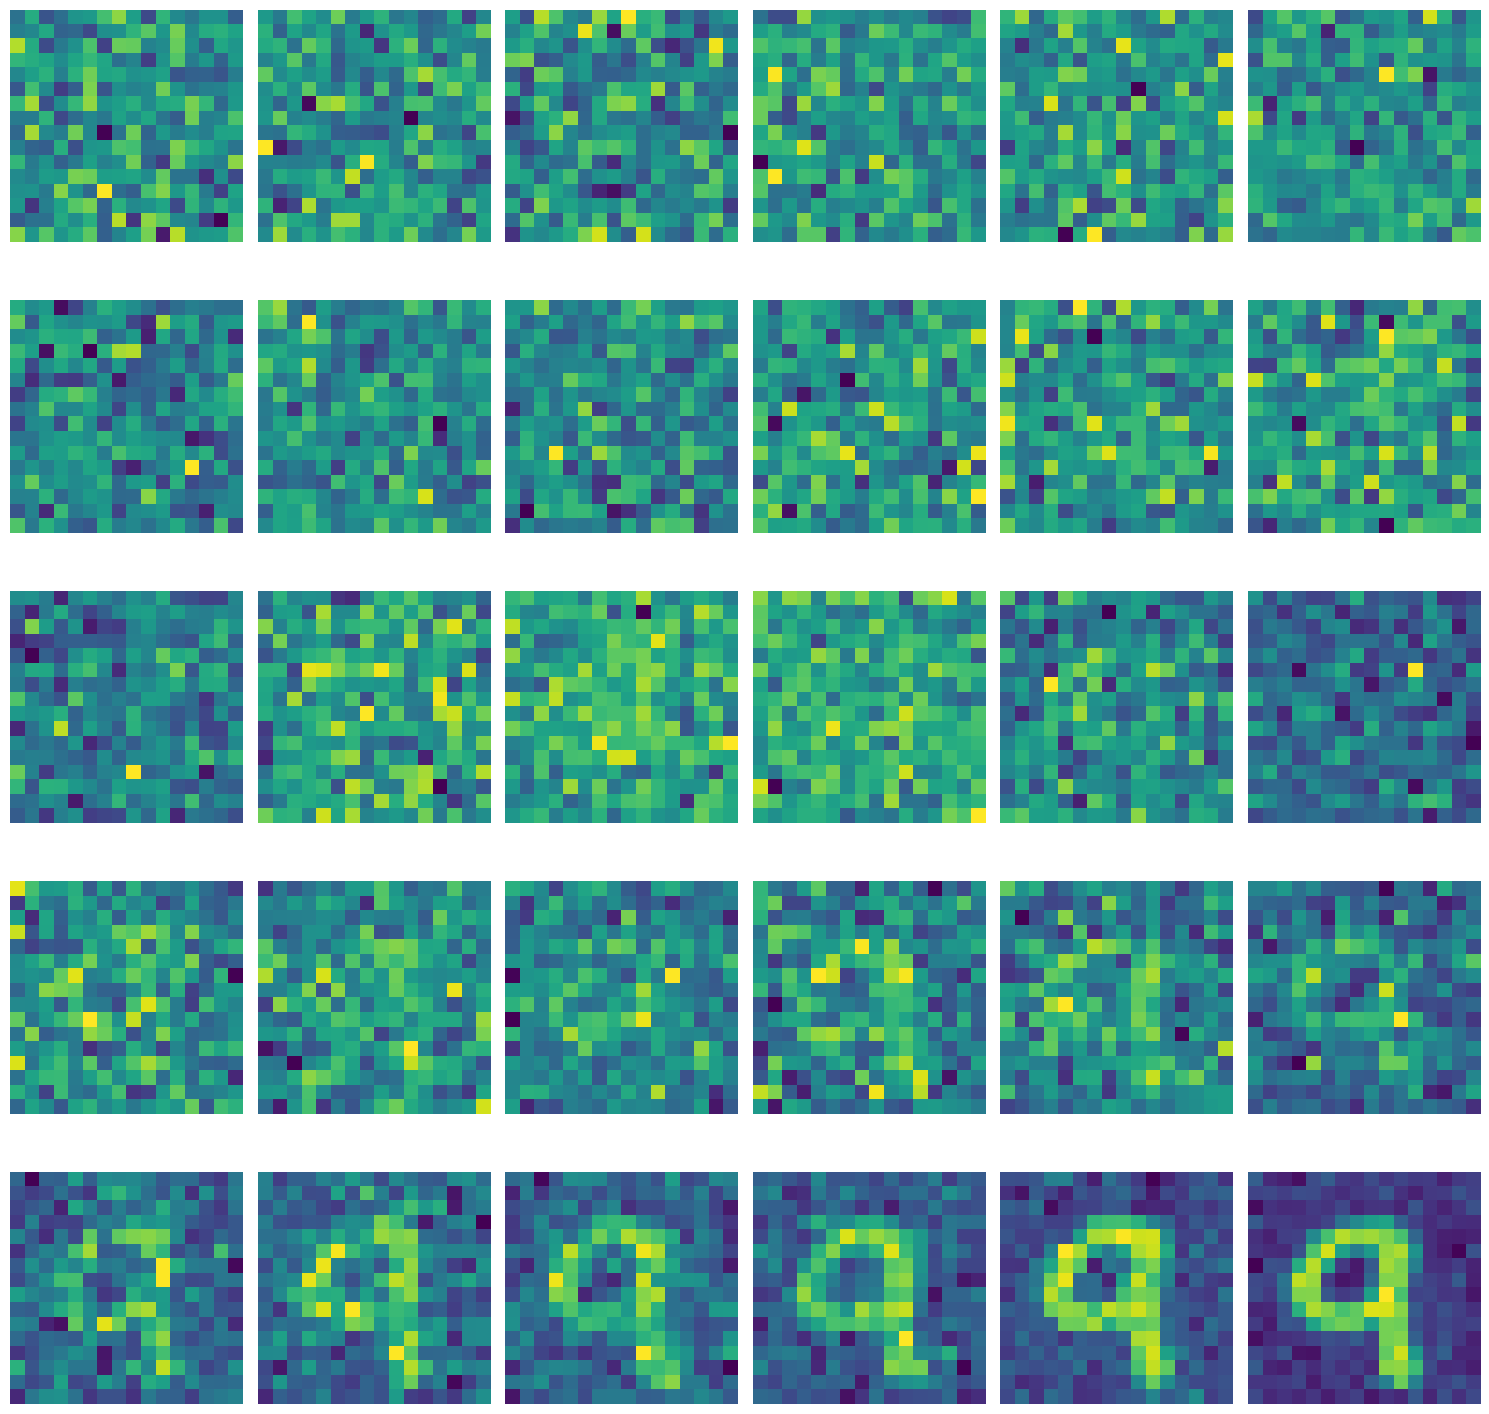

In [22]:
import torch
import matplotlib.pyplot as plt
t = torch.tensor([299])
x = img.unsqueeze(0)
x = x * 2 - 1 # convert [0, 1] to [-1, 1]

rows = 5
cols = 6
num_images_to_display = rows * cols  # 30 images
total_timesteps = 1000
step = total_timesteps // num_images_to_display # 10

fig, axes = plt.subplots(rows, cols, figsize=(15, 15))
axes = axes.flatten()

for i in range(num_images_to_display):
    timestep = total_timesteps - 1 - (i * step)  # Calculate the timestep
    t = torch.tensor([timestep], dtype=torch.long)
    add_noise_img, noise = model.get_noise(x, t)

    final_img = (add_noise_img + 1) / 2  # Convert [-1, 1] to [0, 1]

    if final_img.ndim == 4:
        final_img = final_img.squeeze(0)

    final_img = final_img.permute(1, 2, 0).cpu().numpy()

    axes[i].imshow(final_img)
    axes[i].axis('off')

plt.tight_layout()
plt.show()

train

In [6]:
from utils.train import train_safetensors_save_file
import torch

optimizer = torch.optim.AdamW(model.parameters(), lr=3e-4)
epochs = 500
min_loss = 0.005
model_number = 0
save_model_dir = 'model'
save_model_epochs = 1

train_safetensors_save_file(save_model_dir, epochs, min_loss, save_model_epochs, model, dataloader, optimizer)

Epoch 13/500:   4%|▍         | 8/200 [00:04<01:53,  1.69it/s, loss=0.11] 


KeyboardInterrupt: 

fine-tune

In [34]:
from utils.train import fine_tuned_safetensors_load_file_model
import torch

optimizer = torch.optim.AdamW(model.parameters(), lr=1e-5)
epochs = 500
min_loss = 0.05
model_number = 0
save_model_dir = 'model'
pre_train_model_path = "model/fineTuned_weights_epoch_10.safetensors"
save_model_epochs = 60

fine_tuned_safetensors_load_file_model(save_model_dir, pre_train_model_path, epochs, min_loss=min_loss, save_model_epochs=save_model_epochs, model=model, dataloader=dataloader, optimizer=optimizer)

Epoch 363/500:  36%|███▌      | 72/200 [00:38<01:07,  1.89it/s, loss=0.077] 


KeyboardInterrupt: 

test: inference

In [126]:
import torch
import matplotlib.pyplot as plt
import os
from safetensors.torch import load_file, load_model

def backward_denoise(model: object, model_path: str, img: torch.Tensor, classes: torch.Tensor, time_step):
    assert os.path.exists(model_path), f"model_path not exist"

    model.eval()
    model_path = load_file(model_path)
    model.load_state_dict(model_path)
    denoised_images = [img.clone(), ] # get the origin noise img
    # get the denoise parameters
    alphas, variance, alphas_cumprod = model.get_noise._create_noise_parameters(time_step)

    # from time_step to 0.
    for time in range(time_step - 1, -1, -1):
        t = torch.full((img.size(0),), time) # (time * batch_size)
        noise = model.generate(img, t, classes) # get the denoise img
        shape = (img.size(0), 1, 1, 1)
        mean = 1 / torch.sqrt(alphas[t].view(*shape)) * \
            (img - (1 - alphas[t].view(*shape))/torch.sqrt(1 - alphas_cumprod[t].view(*shape)) * noise)
        if time != 0:
            img = mean + torch.randn_like(img) * \
                torch.sqrt(variance[t].view(*shape))
        else:
            img = mean
        img = torch.clamp(img, -1.0, 1.0).detach() # make sure the img value in the range(-1.0, 1.0) and dont inpput compute the model grdient update
        denoised_images.append(img) # add current denoised image
    return denoised_images

In [116]:
import matplotlib.pyplot as plt
model_path = "model/fineTuned_weights_epoch_360.safetensors"
img = torch.rand(size=(1, 1, 16, 16)) # (batch_size, channel, img_h, img_w)

# classes = torch.tensor(0, dtype=torch.long)
# classes = torch.arange(start=0, end=10, step=1, dtype=torch.long)
classes = torch.tensor([6], dtype=torch.long)
denoise_img = backward_denoise(model, model_path, img, classes, time_step=500)

show the origin noise

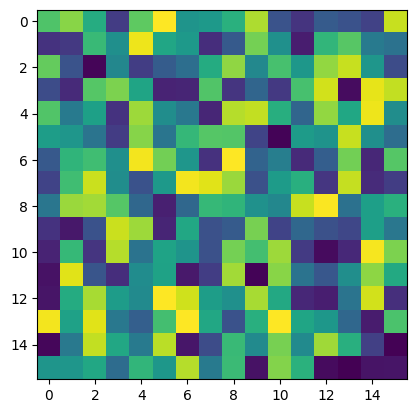

In [45]:
plt.imshow(img.squeeze(0).permute(1,2,0))

generate denoise image

(-0.5, 15.5, 15.5, -0.5)

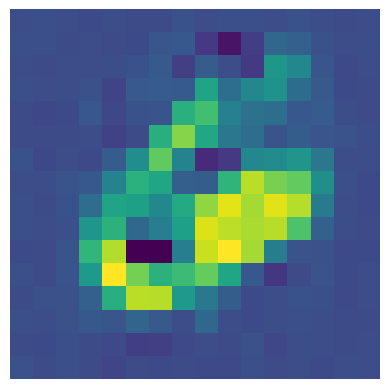

In [118]:
plt.imshow(((denoise_img[-1] + 1) / 2).squeeze(0).permute(1,2,0).cpu().numpy())
plt.axis('off')

show denoise process

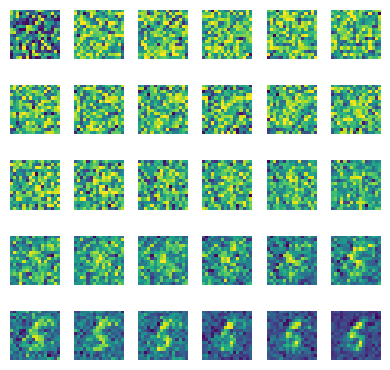

In [113]:
rows = 5
cols = 6
num_images_to_display = rows * cols  # 30 images
total_timesteps = 500
step = total_timesteps // num_images_to_display # 40

fig, axes = plt.subplots(rows, cols, figsize=(4,4))
axes = axes.flatten()

for i in range(num_images_to_display):
    timestep = total_timesteps - 1 - (i * step)
    img_show = denoise_img[total_timesteps - 1 - timestep].squeeze(0) # show the last denoise image
    img_show = (img_show + 1) / 2 # convert [-1, 1] to [0, 1]
    if img_show.ndim == 4:
        img_show = img_show.squeeze(0)
    img_show = img_show.permute(1,2,0).cpu().numpy()
    axes[i].imshow(img_show)
    axes[i].axis('off')

plt.tight_layout()
plt.show()